In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
from scipy.signal import find_peaks, savgol_filter, detrend
from scipy.stats import pearsonr

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tools.analysis import *
from tools.outliers import MonteCarloOutliers
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.utils import shuffle

In [3]:
from boxsers.preprocessing import rubberband_baseline_cor

In [4]:
def corr_plot(X, y):
    r, p_val = pearsonr(X, y)
    
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(min(X), max(X))
    predicted = model.predict(x_range.reshape(-1, 1))
    
    if p_val < 0.00001:
        text = f"$R = {r:.3f}$\n$p < 0.00001$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
    else:
        text = f"$R = {r:.3f}$\n$p = {p_val:.5f}$\n$y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}$"
        
    plt.scatter(X, y, facecolor='w', edgecolor='k')
    plt.plot(x_range, predicted, color='r', linewidth=1.5)
    plt.xlabel("$y_1$")
    plt.ylabel("$y_2$")

    x_offset = (max(X) - min(X)) * 0.02
    y_offset = (max(y) - min(y)) * 0.02
    text_x = min(X)
    text_y = max(y)

    print(text)
    
    plt.text(text_x, text_y, text, verticalalignment='top')

In [5]:
def detrend_spectrum(spectrum, order):
    x = np.arange(len(spectrum))
    p = np.polyfit(x, spectrum, order)
    baseline = np.polyval(p, x)
    return spectrum - baseline

294


<Axes: >

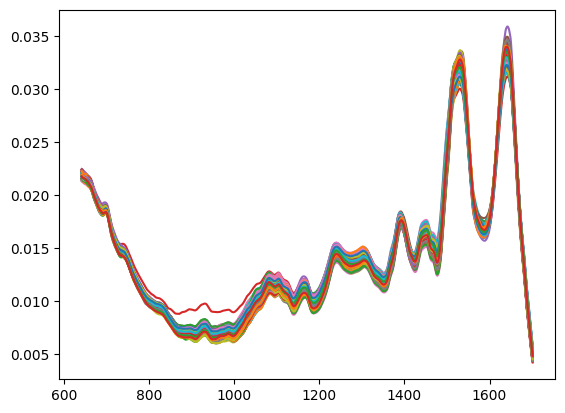

In [8]:
df = pd.read_csv('data/dataset.csv')
domain = pd.read_csv('data/domain.csv')

#df = df[df['HbA1c'] < 10]
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.3 else False, axis=1)
df = df[max_abs]
#df = df[df['HbA1c'] < 12]
print(len(df))

X = df.drop(columns=['HbA1c', 'years'])
y = df['HbA1c']
years = df['years']
X.columns = np.ravel(domain)

#X = X.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
#X = X.apply(lambda row: row / max(row.iloc[1000:]), axis=1)
X = X.T.apply(lambda col: savgol_filter(col, window_length=12, polyorder=1)).T
X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)
#X = X.apply(lambda row: detrend_spectrum(row, 1), axis=1)
#X.T.plot(legend=False)
X.iloc[:, 500:2700].T.plot(legend=False)

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.0556             │
│ R2 = 0.6903               │
│ R = 0.8350                │
│ Number of components = 10 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

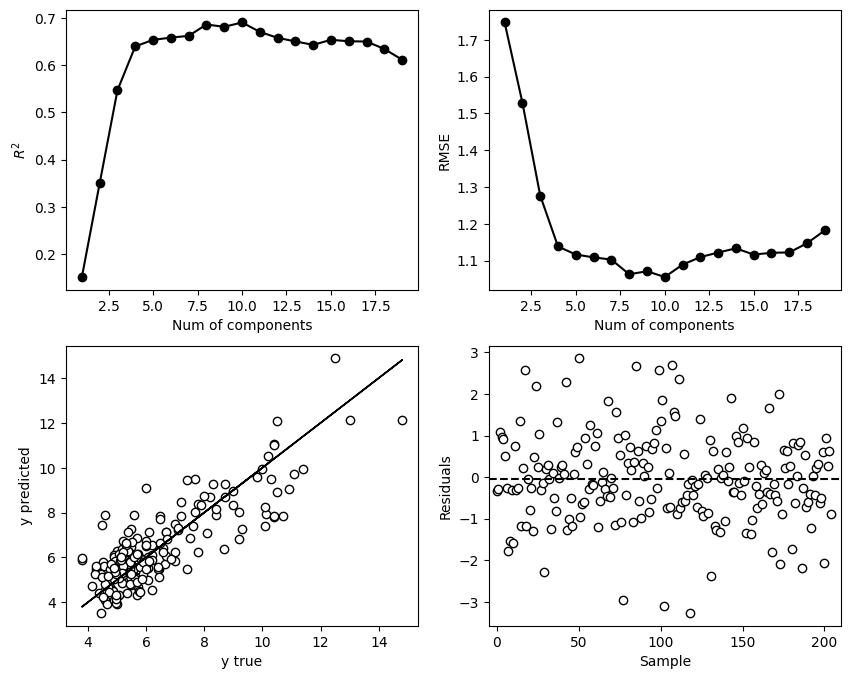

In [9]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None, random_state=24)
categories = discretizer.fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 500:2700], y, test_size=0.3, stratify=categories, random_state=44)

plot_number_components(X_train, y_train, cv=10)

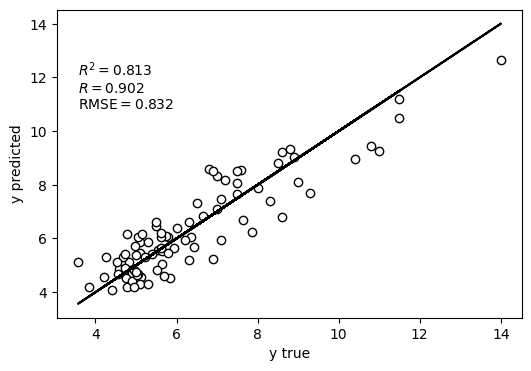

In [10]:
pls = PLSRegression(n_components=10)
pls.fit(X_train, y_train)
y_pred = pls.predict(X_test)
fig, axs = plsr_r2_plot(y_test, y_pred)

In [12]:
# %%time

# w_p1_rmse = []
# w_p1_r2 = []

# for window in range(5, 30, 1):
#     X = df.drop(columns=['HbA1c', 'years'])
#     y = df['HbA1c']
#     years = df['years']
#     X.columns = np.ravel(domain)
#     X = X.T.apply(lambda col: savgol_filter(col, window_length=window, polyorder=1)).T
#     X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 1000:2700], y, test_size=0.3, stratify=categories, random_state=44)

#     n, r2, rmse = find_number_components(X_train, y_train, cv=10, returns='values', number_range=(1, 15), message=False)
#     w_p1_rmse.append(rmse)
#     w_p1_r2.append(r2)

# w_p2_rmse = []
# w_p2_r2 = []

# for window in range(5, 30, 1):
#     X = df.drop(columns=['HbA1c', 'years'])
#     y = df['HbA1c']
#     years = df['years']
#     X.columns = np.ravel(domain)
#     X = X.T.apply(lambda col: savgol_filter(col, window_length=window, polyorder=2)).T
#     X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 1000:2700], y, test_size=0.3, stratify=categories, random_state=44)

#     n, r2, rmse = find_number_components(X_train, y_train, cv=10, returns='values', number_range=(1, 15), message=False)
#     w_p2_rmse.append(rmse)
#     w_p2_r2.append(r2)

# w_p3_rmse = []
# w_p3_r2 = []

# for window in range(5, 30, 1):
#     X = df.drop(columns=['HbA1c', 'years'])
#     y = df['HbA1c']
#     years = df['years']
#     X.columns = np.ravel(domain)
#     X = X.T.apply(lambda col: savgol_filter(col, window_length=window, polyorder=3)).T
#     X = X.apply(lambda row: row / np.linalg.norm(row), axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, 1000:2700], y, test_size=0.3, stratify=categories, random_state=44)

#     n, r2, rmse = find_number_components(X_train, y_train, cv=10, returns='values', number_range=(1, 15), message=False)
#     w_p3_rmse.append(rmse)
#     w_p3_r2.append(r2)

In [13]:
# plt.plot(range(5, 30, 1), w_p1_rmse, marker='o', markerfacecolor='r', markeredgecolor='k', color='b', label='polyorder 1')
# plt.plot(range(5, 30, 1), w_p2_rmse, marker='o', markerfacecolor='orange', markeredgecolor='k', color='b', label='polyorder 2')
# plt.legend()

In [14]:
# plt.plot(range(5, 30, 1), w_p1_r2, marker='o', markerfacecolor='r', markeredgecolor='k', color='b', label='polyorder 1')
# plt.plot(range(5, 30, 1), w_p2_r2, marker='o', markerfacecolor='orange', markeredgecolor='k', color='b', label='polyorder 2')
# #plt.plot(range(5, 30, 1), w_p3_r2, marker='o', markerfacecolor='pink', markeredgecolor='k', color='b', label='polyorder 3')
# plt.legend()
# plt.savefig("optimal_savgol.png", dpi=250)
# print("p1 = ", np.max(w_p1_r2), range(5, 30, 1)[np.argmax(w_p1_r2)])
# print("p2 = ", np.max(w_p2_r2), range(5, 30, 1)[np.argmax(w_p2_r2)])
# print("p3 = ", np.max(w_p3_r2), range(5, 30, 1)[np.argmax(w_p2_r2)])

In [25]:
from auswahl import CARS, VISSA, IPLS

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=categories, random_state=44)

cars = CARS()
cars.fit(X_train, y_train)
idx = cars.get_support()

┌──────────────────────────┐
│       FIT RESULTS        │
├──────────────────────────┤
│ RMSE = 1.0982            │
│ R2 = 0.6648              │
│ R = 0.8180               │
│ Number of components = 9 │
└──────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

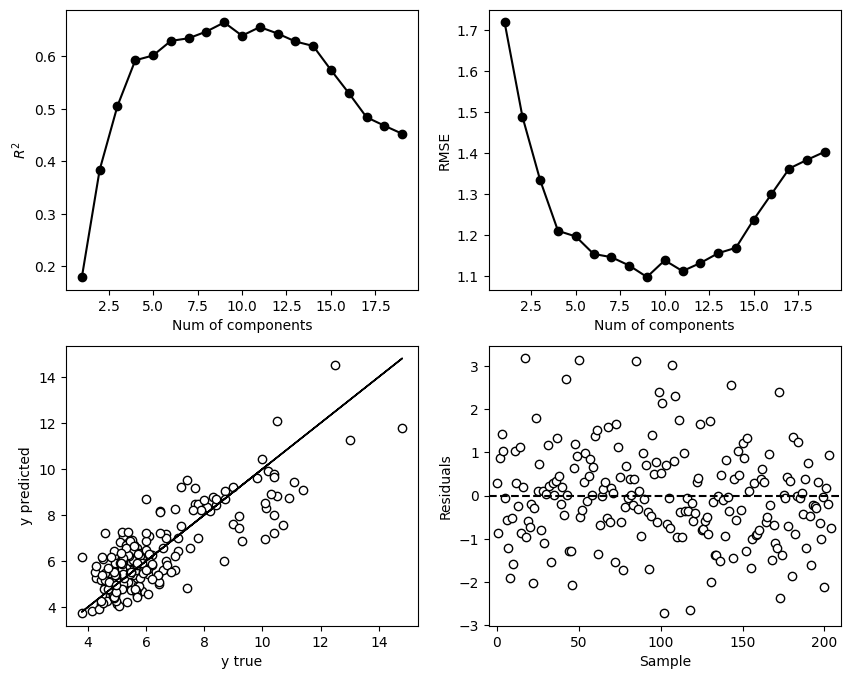

In [17]:
plot_number_components(X_train.iloc[:, idx], y_train, cv=10)

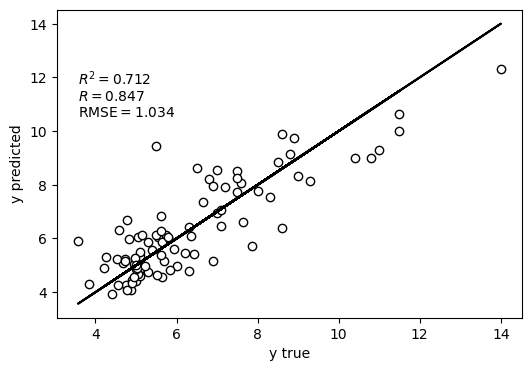

In [18]:
pls = PLSRegression(n_components=9)
pls.fit(X_train.iloc[:, idx], y_train)
y_pred = pls.predict(X_test.iloc[:, idx])
fig, axs = plsr_r2_plot(y_test, y_pred)

<BarContainer object of 3734 artists>

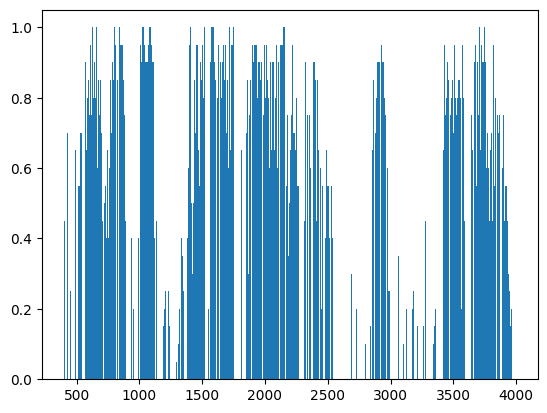

In [19]:
plt.bar(np.ravel(domain)[idx], cars.feature_importance_[idx])

In [20]:
vissa = VISSA(n_submodels=1000)
vissa.fit(X_train, y_train)

VISSA()

<BarContainer object of 3734 artists>

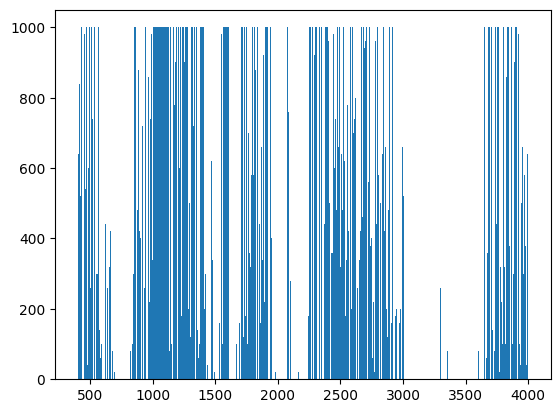

In [21]:
idx = vissa.get_support()
plt.bar(np.ravel(domain)[idx], vissa.frequency_[idx])

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.0850             │
│ R2 = 0.6728               │
│ R = 0.8263                │
│ Number of components = 11 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

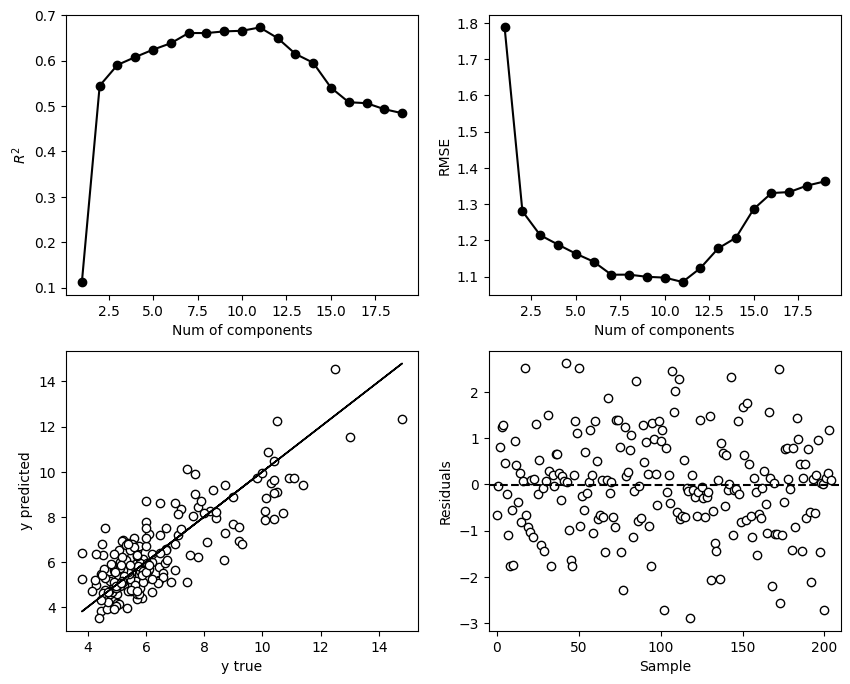

In [22]:
plot_number_components(X_train.iloc[:, idx], y_train, cv=10)

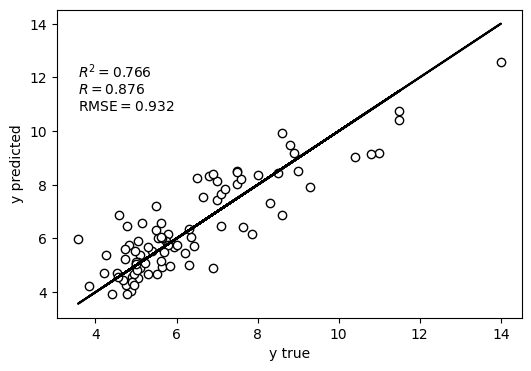

In [24]:
pls = PLSRegression(n_components=8)
pls.fit(X_train.iloc[:, idx], y_train)
y_pred = pls.predict(X_test.iloc[:, idx])
fig, axs = plsr_r2_plot(y_test, y_pred)

In [32]:
ipls = IPLS(interval_width=2000)
ipls.fit(X_train, y_train)

IPLS(interval_width=2000)

<BarContainer object of 7468 artists>

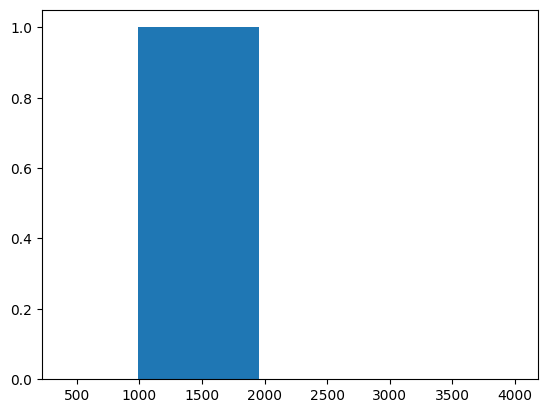

In [33]:
idx = ipls.get_support()
plt.bar(np.ravel(domain), ipls.get_support())

(0.0, 0.034)

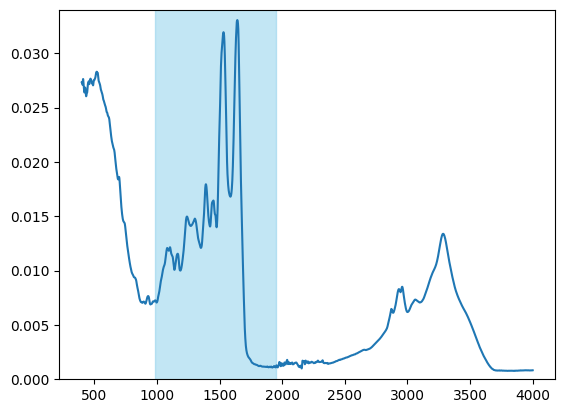

In [44]:
X.iloc[0].plot()
plt.fill_betweenx(plt.ylim(), min(np.ravel(domain)[idx]), max(np.ravel(domain)[idx]), alpha=0.5, color='skyblue')
plt.ylim([0, 0.034])

┌───────────────────────────┐
│        FIT RESULTS        │
├───────────────────────────┤
│ RMSE = 1.0621             │
│ R2 = 0.6865               │
│ R = 0.8330                │
│ Number of components = 15 │
└───────────────────────────┘


(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Num of components', ylabel='$R^2$'>,
         <Axes: xlabel='Num of components', ylabel='RMSE'>],
        [<Axes: xlabel='y true', ylabel='y predicted'>,
         <Axes: xlabel='Sample', ylabel='Residuals'>]], dtype=object))

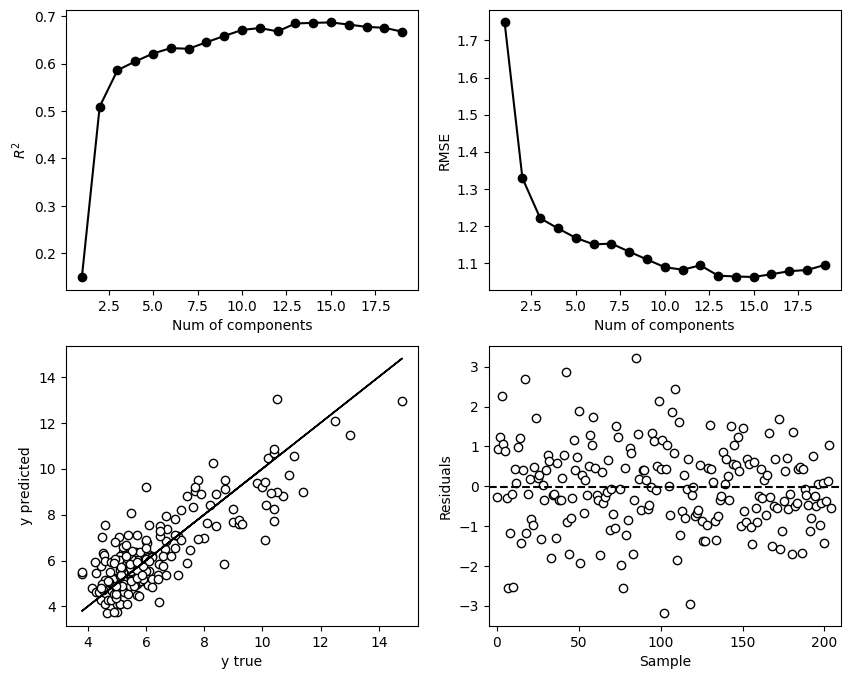

In [34]:
plot_number_components(X_train.iloc[:, idx], y_train, cv=10)